In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
sns.set(style = "whitegrid", color_codes = True)
sns.set(font_scale = 1)
#from astropy.table import Table, Column
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, KFold
from sklearn.naive_bayes import BernoulliNB
#import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import clone

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, mean_squared_error
import pickle
import random
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

%load_ext autotime

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tu/miniconda3/envs/env36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Drop all columns which have percentage of missing values superior threshold
class DropColumnsWithMissingData(BaseEstimator, TransformerMixin):
    """
    drop all columns which have percentage of missing values superior threshold
    """
    def __init__(self, thresholds=0.40):
        self.thresholds = thresholds
    
    def fit(self, X, y=None):
        a = X.isnull().mean()
        self.kept_columns = a.index[a < self.thresholds].tolist()
        return self
    
    def transform(self, X):
        return X[self.kept_columns]

time: 9.74 ms


In [3]:
class select_features(BaseEstimator, TransformerMixin):
    """
    Select categorical features or numerical features 
    """
    def __init__(self, features):
        self.features = features
         
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features]

    
class FillMissingValues(BaseEstimator, TransformerMixin):
    """
    Fill missing values 
    'nan' for categorical features
    or -999 for numerical features
    """
    
    def __init__(self, replace_value):
        self.replace_value = replace_value
        # replace_value = 'nan' for filling missing data in categorical features
        # or -999 in numerical features
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.fillna(self.replace_value)
    
    
class ColumnApplier(BaseEstimator, TransformerMixin):
    """
    Some sklearn transformers can apply only on ONE column at a time (such as LabelEnconder())
    Wrap them with ColumnApplier to apply on all columns in the dataset
    """

    def __init__(self, underlying):
        self.underlying = underlying
        #TODO: underlying is one model method

    def fit(self, X, y=None):
        m = {}
        X = pd.DataFrame(X)  # TODO: :( reimplement in pure numpy?
        for c in X.columns:
            k = clone(self.underlying) 
            #TODO: clone helps to construct a new estimator with the same parameters.
            #      deep copy of the model in an estimator without actually copying attached data
            
            k.fit(X[c])
            # fit model k for every column in X 
            
            m[c] = k
            # put it in dictionary with column c as key and k as items
        
        self._column_stages = m
        # self.column_stages is a dictionary with column c in X as key and model k.fit as items 
        return self

    def transform(self, X):
        ret = {}
        X = pd.DataFrame(X)
        for c, k in self._column_stages.items():
            ret[c] = k.transform(X[c])
            # ret is a dict which has c as key and k.transform as items
        return pd.DataFrame(ret)[X.columns]  # keep the same order

class TolerantLabelEncoder(LabelEncoder):
    """
    LabelEncoder is not tolerant to unseen values
    """
    def transform(self, y):
        return np.searchsorted(self.classes_, y)

time: 114 ms


## Import data

In [60]:
#Import training data
train = pd.read_csv("data/train.csv")
#Import test data
test = pd.read_csv("data/test.csv")

time: 38 ms


In [61]:
train.drop(['Id'], axis= 1, inplace= True)
testId = test.Id
test.drop(['Id'], axis= 1 , inplace= True)

time: 6.02 ms


In [62]:
Xtrain = train.ix[:, train.columns != 'SalePrice']
ytrain = train.SalePrice

time: 3.82 ms


## Encoding pipeline

In [63]:
X_train = DropColumnsWithMissingData(thresholds=0.90).fit_transform(Xtrain)

CAT = X_train.select_dtypes(include=["object"]).columns
NUM = X_train.select_dtypes(exclude=["object"]).columns

time: 15.5 ms


In [64]:
# Label Encoding
preproc_le = make_pipeline (
    DropColumnsWithMissingData(thresholds=0.90),
    make_union(make_pipeline(
        select_features(CAT),
        FillMissingValues('nan'),
        ColumnApplier(TolerantLabelEncoder())
    ),
    make_pipeline(
        select_features(NUM),
        FillMissingValues(-999),
        StandardScaler()
    )
  )
)

time: 4.44 ms


In [65]:
### One-hot Encoding
preproc_ohe = make_pipeline (
    DropColumnsWithMissingData(thresholds=0.9),
    make_union(
    make_pipeline(
        select_features(CAT),
        FillMissingValues('nan'),
        ColumnApplier(TolerantLabelEncoder()),
        OneHotEncoder(handle_unknown = 'ignore')
    ),
    make_pipeline(
        select_features(NUM),
        FillMissingValues(-999),
        StandardScaler()        
    )
  )
)

time: 5.34 ms


## Split training data set into 2 part: train et test

In [75]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, ytrain, test_size = 0.2)

time: 3.75 ms


## XGBoost with random search or GridSearch

#### Predict results of Xtest

In [22]:
xgb = make_pipeline(
            preproc_ohe, 
            GridSearchCV(
                XGBRegressor(),
                param_grid = {'n_estimators' : [30, 100, 300, 800],
                                        'max_depth' : [ 3, 5, 7] },
                cv = 5,
                verbose = 1,
                error_score = "neg_mean_squared_error"
                )
            )

time: 3.21 ms


In [23]:
xgb.fit(Xtrain, ytrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.3min finished


Pipeline(steps=[('pipeline', Pipeline(steps=[('dropcolumnswithmissingdata', DropColumnsWithMissingData(thresholds=0.9)), ('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('select_features', select_features(features=Index(['MSZoning', 'Street', 'LotShape', 'LandC...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1))])

time: 1min 18s


In [25]:
predicted_y = xgb.predict(test)

time: 176 ms


In [32]:
predicted_y

array([ 128020.78125 ,  165197.15625 ,  180653.90625 , ...,  153075.96875 ,
        114660.984375,  225877.765625], dtype=float32)

time: 2.81 ms


In [76]:
model_xgb = make_pipeline(
            preproc_ohe,
            XGBRegressor(learning_rate= 0.1))

time: 1.22 ms


In [78]:
model_xgb.fit(Xtrain, Ytrain)

Pipeline(steps=[('pipeline', Pipeline(steps=[('dropcolumnswithmissingdata', DropColumnsWithMissingData(thresholds=0.9)), ('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('select_features', select_features(features=Index(['MSZoning', 'Street', 'LotShape', 'LandC...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

time: 354 ms


In [83]:
feature_impact = compute_features_impact(model_xgb, Xtest, Ytest)

time: 2.92 s


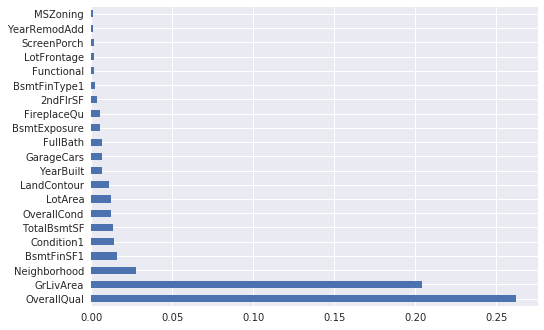

time: 382 ms


In [88]:
feature_impact[feature_impact >0.001].plot(kind = 'barh')

## With hyperband and Xgboost

In [74]:
from dodoml.ml import Hyperband
from dodoml.ml import xgboost_hyperband_regressor
from dodoml import compute_features_impact, compute_partial_dependence
from scipy.stats.distributions import uniform, randint

time: 2.15 ms


In [89]:
param_space = {
    'max_depth': randint(2, 11),
    'min_child_weight': randint(1, 11),
    'subsample': uniform(0.5, 0.5),
}

model = make_pipeline(
    preproc_ohe,
    Hyperband(
        XGBRegressor(learning_rate=0.1),
        feat_space=param_space,
        task='Regression'
    )
)


time: 6.24 ms


In [90]:
model.fit(Xtrain, Ytrain)

Pipeline(steps=[('pipeline', Pipeline(steps=[('dropcolumnswithmissingdata', DropColumnsWithMissingData(thresholds=0.9)), ('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('select_features', select_features(features=Index(['MSZoning', 'Street', 'LotShape', 'LandC...rastructure.rv_frozen object at 0x7fe3e4f0ec18>},
     max_iter=81, model=None, task='Regression'))])

time: 31 s


In [104]:
y_predict_hyperband = model.predict(Xtest)

time: 40.6 ms


In [91]:
feature_impact_hyperband = compute_features_impact(model, Xtest, Ytest)

time: 3.14 s


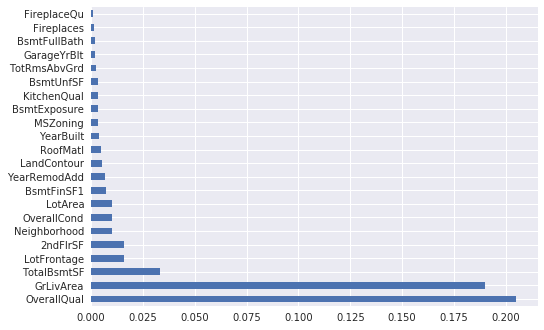

time: 479 ms


In [92]:
feature_impact_hyperband[feature_impact_hyperband > 0.001].plot(kind = 'barh')

In [102]:
feature_impact_hyperband[feature_impact_hyperband > 0.005].index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', '2ndFlrSF',
       'Neighborhood', 'OverallCond', 'LotArea', 'BsmtFinSF1', 'YearRemodAdd',
       'LandContour'],
      dtype='object')

time: 3.49 ms


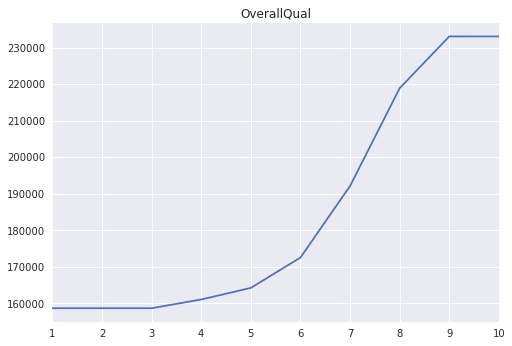

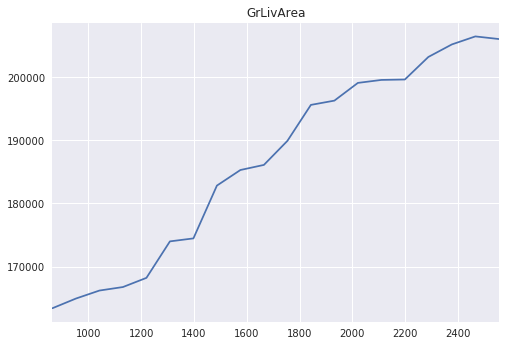

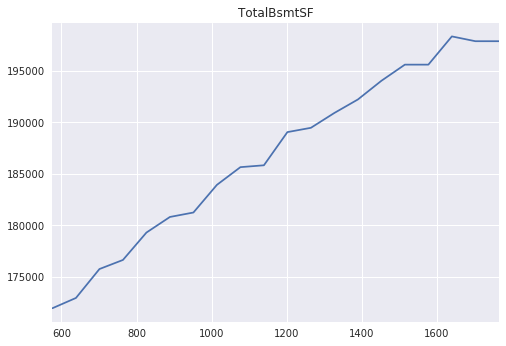

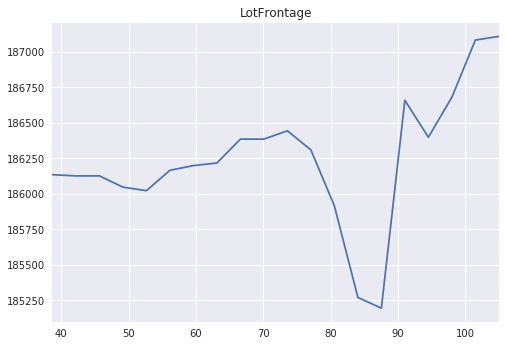

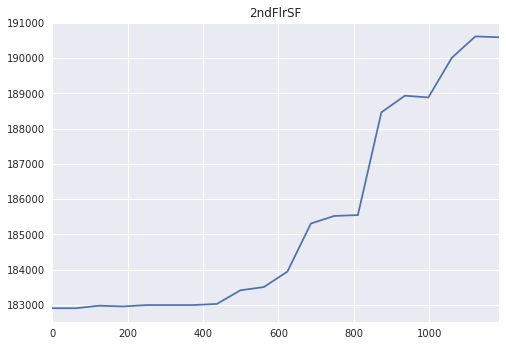

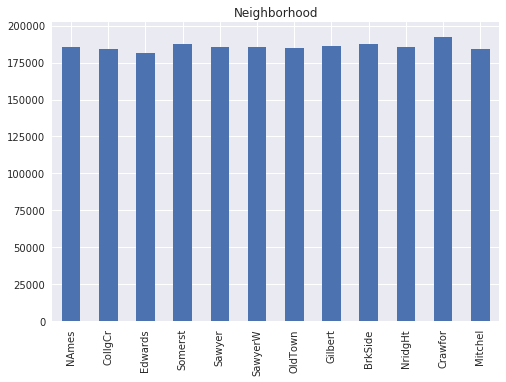

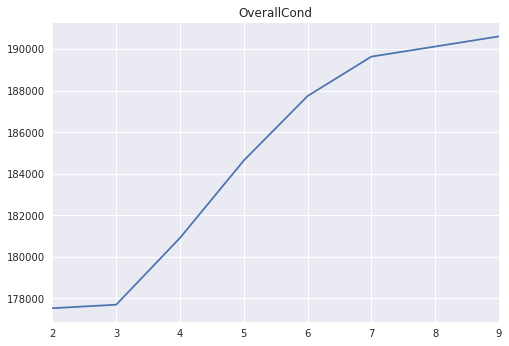

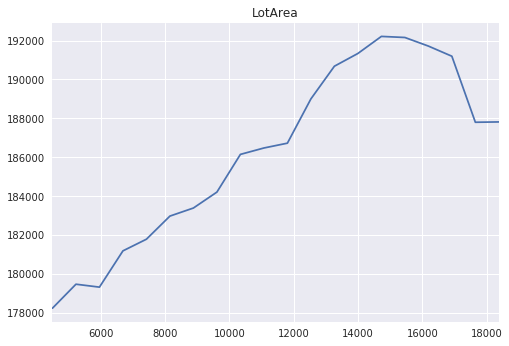

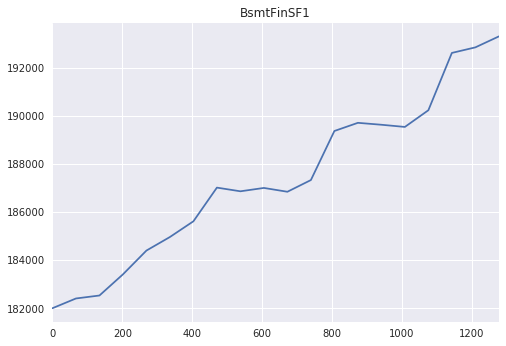

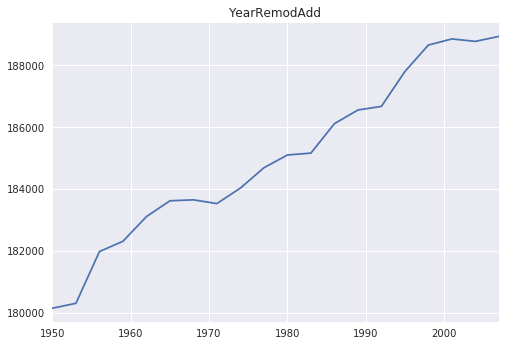

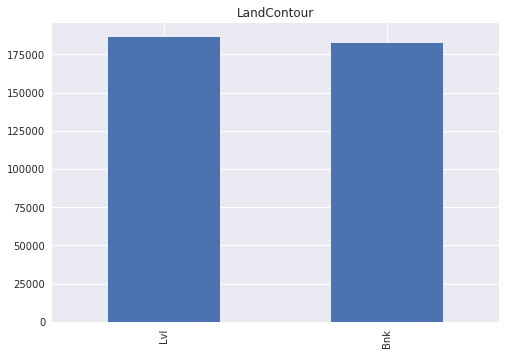

time: 11.8 s


In [103]:
for feature, series in compute_partial_dependence(model, Xtest, features= feature_impact_hyperband[feature_impact_hyperband > 0.005].index, row_sample= 100000):
    if series.shape[0] > 0:
        if feature in CAT:
            series.plot(kind='bar')
        else:
            series.plot(kind='line')
        plt.title(feature)
        plt.show()

### Backtest model

In [109]:
def mse(ytest, ypredict):
    return np.sqrt(mean_squared_error(np.log(ytest), np.log(ypredict)))

time: 1.47 ms


In [110]:
mse(Ytest, y_predict_hyperband)

0.13932135669545828

time: 3.19 ms


## Output results

In [70]:
pd.DataFrame({"Id": testId, "SalePrice": y_predict_hyperband}).to_csv('predicted_result/predict_xgboost_hyperband.csv', index = False)

time: 7.93 ms
